In [1]:
# Load general packages
import pandas as pd
import numpy as np
# Load training packages
from training_utils import *
from results import *
# from preprocessing_utils import *
from sklearn.model_selection import train_test_split
from sklearn.calibration import IsotonicRegression
# Load all machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Load shap package
import shap
shap.initjs()

In [2]:
# Read data file
# Data is obtained from: https://www.kaggle.com/competitions/gusto-1
data_path = '/Users/annedehond 1/Documents/UMCU/Explainability viewpoint/gusto-1/'
data = pd.read_csv(data_path+'train.csv')

# Select predictor and outcome variables
data_X = data.loc[:,['AGE','SEX','HYP','HRT','ANT','PMI','HEI','WEI','STE','TTR']]
data_X.columns = ['age','sex: female','hypotension: systolic BP under 100','heart rate: pulse over 80',
    'anterior infarct location','previous myocardial infarction','height','weight', 
    'ST elevation on ECG: number of leads','time to relief of chest pain over 1 hour']
data_y = data['DAY30']

Some background information on the dataset:
Acute myocardial infarction (heart attack) is caused by the formation of a clot in one of the coronary arteries that supply blood to the heart muscle. Acute MI is a major public health problem. The age-adjusted incidence of hospitalization for myocardial infarction is around 2 per 1,000 women and 4 per 1,000 for men in the United States. Mortality is substantial in the period immediately after the event, and also during the years after surviving the initial infarction. Some patients die before reaching hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics include the location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patient as reflected by blood pressure, heart rate, and left ventricular function (Killip class, presence of shock).

In [3]:
data_X.head()

,age,sex: female,hypotension: systolic BP under 100,heart rate: pulse over 80,anterior infarct location,previous myocardial infarction,height,weight,ST elevation on ECG: number of leads,time to relief of chest pain over 1 hour
0,70.313,0,0,0,1,0,177.3,84.0,1,1
1,59.844,0,0,0,1,0,172.0,115.0,6,0
2,59.023,0,0,1,0,0,170.0,76.0,3,0
3,80.375,1,0,1,0,0,154.9,50.0,3,0
4,64.750,0,1,0,0,0,167.0,97.4,2,1


In [4]:
# Generate a stratified split train and test set
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, stratify=data_y, train_size=2/3)

In [5]:
# Train the random forest
model_specification = {'model':XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'pbounds':{'max_depth':[2,15], 'n_estimators':[100,200]},
        'integer_params':{'max_depth':True, 'n_estimators':True},
        'X':train_X, 'y':train_y}

train_prob, test_prob, best_params, xgb_model = train_model(
    model_specifications = model_specification, 
    train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y
)

Best result: {'max_depth': 2.0, 'n_estimators': 105.5096490817061}; f(x) = 0.7921040138558387.
train auc 0.9727988953866146
test auc 0.8176480129764802


In [7]:
# Get performance for uncalibrated probabilities
performance_table(pd.Series(test_y),pd.Series(test_prob[:,1]))

,AUROC,AUPRC,calibration int,calibration slope
0,"0.82 (0.77, 0.86)","0.22 (0.15, 0.31)","-0.02 (-0.38, 0.33)","0.61 (0.44, 0.79)"


In [8]:
# Explain the XGBoost model with SHAP
explainer_xgb = shap.Explainer(xgb_model)
shap_values = explainer_xgb(test_X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [9]:
# Plot data first individual
test_X.head()

,age,sex: female,hypotension: systolic BP under 100,heart rate: pulse over 80,anterior infarct location,previous myocardial infarction,height,weight,ST elevation on ECG: number of leads,time to relief of chest pain over 1 hour
175,59.930,1,0,0,0,0,158.0,68.0,4,0
917,53.820,0,0,0,0,0,160.0,130.0,4,1
1555,59.164,0,0,0,0,1,175.0,73.0,2,1
883,70.469,0,1,0,0,0,180.0,85.0,2,1
1656,60.922,0,0,0,0,0,167.6,62.0,4,0


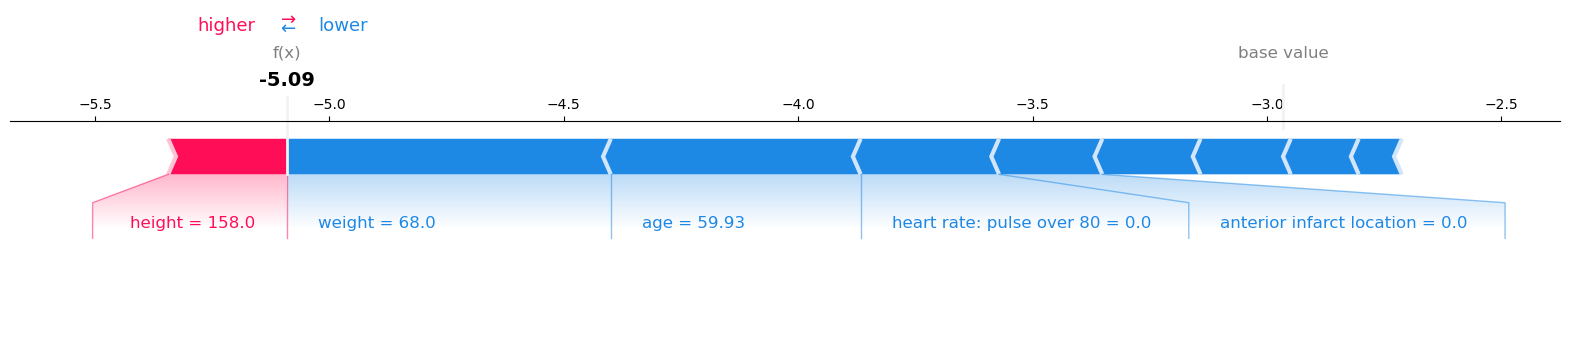

In [14]:
# Plot force plot for individual observation
plt.style.use('default')
force_plot = shap.plots.force(shap_values[0], matplotlib=True, show=False)
plt.savefig('force_plot.pdf', bbox_inches='tight')
plt.show()

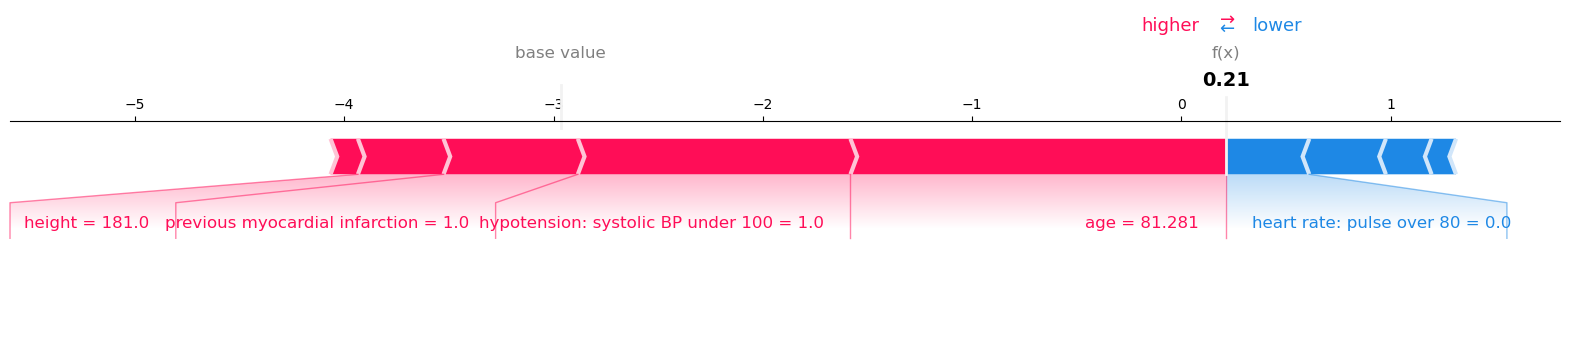

In [58]:
# Plot force plot for individual observation
plt.style.use('default')
force_plot = shap.plots.force(shap_values[215], matplotlib=True, show=False)
plt.savefig('force_plot.pdf', bbox_inches='tight')
plt.show()

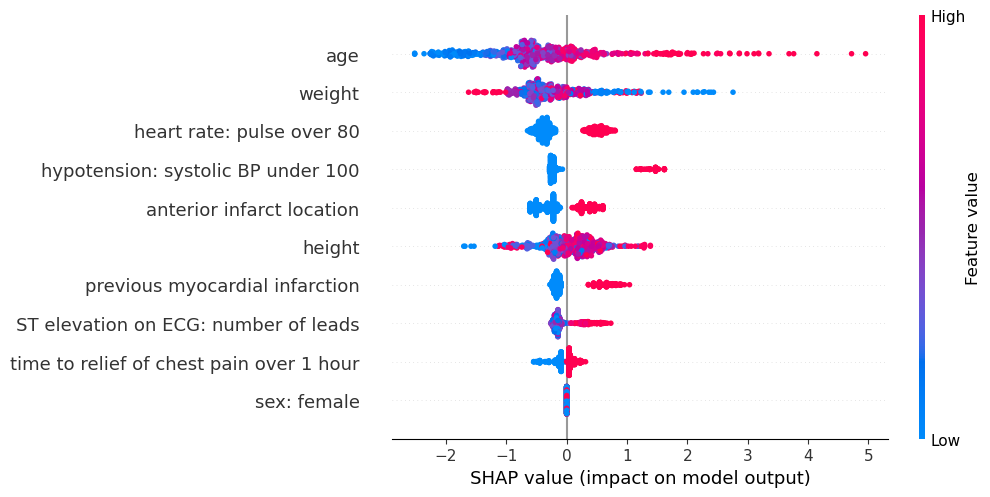

In [59]:
# Plot beeswarm plot for global feature importance
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('beeswarm_plot.pdf', bbox_inches='tight')
plt.show()